##Predicting 30-day mortality for MIMIC-III patients with sepsis using machine learning

Sepsis is a significant risk to ICU patients and cause for in-hospital mortality. Predicting sepsis and being able to address and treat the causes can be life saving for patients in the ICU.

There are ample research papers seeking to predict the 30-day mortality rate for MIMIC-III patients with sepsis. One such paper, "Predicting 30-days mortality for MIMIC-III patients with sepsis-3: a machine learning approach using XGboost" by Hou et al, seeks to use XGBoost as an alternative means to prediction versus more traditional approaches such as SAPS-II score prediction and logistic regression. The paper concludes that XGBoost provides superior results to the traditional approaches.

This tutorial will look to reproduce the XGBoost results and compare to two new machine learning approaches (LightGBM and CatBoost) along with ways to finetune hyperparameters for these models which may yield improved prediction ability relative to the work done by the authors of the referenced paper.

In [1]:
#Load a few of the libraries/functions needed for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

Load and Prepare Data

Patient data was extracted by the authors from the MIMIC-III database with the following characteristics as defined in the paper.

Initial Universe: Adult patients who were diagnosed with sepsis-3

Inclusion criteria were:

1.   Patients older than 18 years old
2.   length of stay in the ICU was over 24 hours
3.   patients diagnosed with sepsis according to icd-9 codes for sepsis, severe sepsis, and septic shock
4.   Exclude patients older than 89 years
5.   Include only the first admission for patients with multiple admissions
6.   Remove variables with more than 20% observations missing
7.   For those with less than 20% missing data or randomly missing data, the authors explored and visualized them with Templ's method and multiple imputation method for further analysis

To ensure consistent data with the research paper, we will use the same data file available via download on the site: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7720497/. Scroll down towards the bottom of the page under "Supplementary information". Click on the link, download the file, and save to either your local machine or to your Google Drive.

In [2]:
#This is the file downloaded from the above website and saved to your local machine.
from google.colab import files
uploaded = files.upload()

Saving 12967_2020_2620_MOESM1_ESM.csv to 12967_2020_2620_MOESM1_ESM.csv


In [3]:
#Create a dataframe for the uploaded data and view
df_sepsis = pd.read_csv('12967_2020_2620_MOESM1_ESM.csv')
df_sepsis.head()

,icustay_id,hadm_id,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,antibiotic_time_poe,...,glucose_min1,glucose_max1,glucose_mean,rrt,subject_id,hadm_id.1,icustay_id.1,urineoutput,colloid_bolus,crystalloid_bolus
0,205941,156324,28/5/2157 14:26:21,30/5/2157 14:18:24,metavision,28/5/2157 15:30:00,-0.044201,MRSA SCREEN,0,28/5/2157 00:00:00,...,40.0,202.0,87.250000,0,88883,156324,205941,0.0,NaN,250.0
1,252848,163315,29/7/2196 02:26:17,29/7/2196 12:02:39,metavision,29/7/2196 04:57:00,-0.104664,MRSA SCREEN,1,29/7/2196 00:00:00,...,182.0,231.0,206.500000,0,46154,163315,252848,0.0,NaN,250.0
2,237901,180937,14/2/2145 17:55:07,23/2/2145 12:43:43,metavision,14/2/2145 21:20:00,-0.142280,BLOOD CULTURE,0,15/2/2145 00:00:00,...,123.0,185.0,151.285714,1,42682,180937,237901,0.0,NaN,250.0
3,207491,143962,11/6/2159 12:47:02,14/6/2159 16:31:30,metavision,11/6/2159 12:11:00,0.025023,BLOOD CULTURE,0,11/6/2159 00:00:00,...,92.0,118.0,105.000000,0,45111,143962,207491,4.0,NaN,250.0
4,293063,118489,1/1/2135 17:28:33,2/1/2135 06:56:56,metavision,1/1/2135 15:55:00,0.064965,BLOOD CULTURE,0,1/1/2135 00:00:00,...,150.0,163.0,155.000000,0,56648,118489,293063,5.0,NaN,250.0


Positive and Negative Samples and Data

View the number of deaths and survivals based on the thirty-day expiry flag as defined in the data file.

In [4]:
print('Number of Patient Deaths within 30 Days:  ', (df_sepsis.thirtyday_expire_flag == 1).sum())
print('Number of Patients Alive after 30 Days:   ',  (df_sepsis.thirtyday_expire_flag == 0).sum())
print('Total samples:                            ', len(df_sepsis))

Number of Patient Deaths within 30 Days:   889
Number of Patients Alive after 30 Days:    3670
Total samples:                             4559


##Sepsis 30-day mortality prediction using XGBoost

The following section looks to reproduce the authors' prediction modeling using XGBoost.

In [5]:
#Split data into input and output arrays
#for the input data, we want to use most of the data columns from the extracted fields
#for the output/target data, we will use the thirtyday_expiry flag indicating death within the 30-day window
#For simplicity, the following code will extract those columns. Later we will run the analysis using the fields as noted in the research paper.

X = df_sepsis[['metastatic_cancer', 'diabetes', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score', 'qsofa_gcs_score', 'qsofa_resprate_score', 'aniongap_min', 'aniongap_max', 'bicarbonate_min', 'bicarbonate_max', 'creatinine_min', 'creatinine_max', 'chloride_min', 'chloride_max', 'glucose_min', 'glucose_max', 'hematocrit_min', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 'lactate_min', 'lactate_max', 'lactate_mean', 'platelet_min', 'platelet_max', 'potassium_min', 'potassium_max', 'inr_min', 'inr_max', 'sodium_min', 'sodium_max', 'bun_min', 'bun_max', 'bun_mean', 'wbc_min', 'wbc_max', 'wbc_mean', 'heartrate_min', 'heartrate_max', 'heartrate_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min1', 'glucose_max1', 'glucose_mean', 'rrt', 'urineoutput', 'colloid_bolus', 'crystalloid_bolus']]
Y = df_sepsis[['thirtyday_expire_flag']]

#Split data into test and training sets
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#Split test data equally into validation and test sets
X_valid = X_test.sample(frac = 0.5, random_state=seed)
X_test  = X_test.drop(X_valid.index)
y_valid = y_test.sample(frac = 0.5, random_state=seed)
y_test  = y_test.drop(y_valid.index)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape)

(3191, 69) (3191, 1) (684, 69) (684, 1) (684, 69) (684, 1)


In [6]:
#Train the model
#Fit the model on training data
model = XGBClassifier()
evalset = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset, verbose=0)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Generate statistics on the model to determine its prediction characteristics

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import multilabel_confusion_matrix

#Make predictions using the XGBoost model

#For AUC, we need to predict the probabilities
y_train_prob  = model.predict_proba(X_train)[:,1]
y_test_prob   = model.predict_proba(X_test)[:,1]
y_valid_prob  = model.predict_proba(X_valid)[:,1]

print('Model AUC')
print('Train AUC:         %.2f%%'%(roc_auc_score(y_train, y_train_prob)*100))
print('Test AUC:          %.2f%%'%(roc_auc_score(y_test, y_test_prob)*100))
print('Valid AUC:         %.2f%%'%(roc_auc_score(y_valid.thirtyday_expire_flag, y_valid_prob)*100))
print('')

#for the following characteristics, we will use the multi-label confusion matrix which is used for evaluating the performance of a machine learning model.
#tn = True Negative; tp = True Positive; fn = False Negative; fp = False Positive

#For characteristics, we need to make predictions, not probabilities
y_test_preds  = model.predict(X_test)
y_train_preds = model.predict(X_train)
y_valid_preds = model.predict(X_valid)

def calc_accuracy(y_actual, y_pred):
  y_true = np.array(y_actual)
  y_pred = y_pred
  mcm = multilabel_confusion_matrix(y_true, y_pred)
  tn = mcm[:, 0, 0]
  tp = mcm[:, 1, 1]
  fn = mcm[:, 1, 0]
  fp = mcm[:, 0, 1]
  accuracy = (tp + tn) / (tp + fp + tn + fn)
  return accuracy[0]

print('Model Accuracy')
print('Train accuracy:    %.2f%%'%(calc_accuracy(y_train, y_train_preds)*100))
print('Test accuracy:     %.2f%%'%(calc_accuracy(y_test, y_test_preds)*100))
print('Valid accuracy:    %.2f%%'%(calc_accuracy(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

def calc_recall(y_actual, y_pred):
  y_true = np.array(y_actual)
  y_pred = y_pred
  mcm = multilabel_confusion_matrix(y_true, y_pred)
  tn = mcm[:, 0, 0]
  tp = mcm[:, 1, 1]
  fn = mcm[:, 1, 0]
  fp = mcm[:, 0, 1]
  recall = tp / (tp + fn)
  return recall[0]

print('Recall: True Positive')
print('Train Recall:      %.2f%%'%(calc_recall(y_train.thirtyday_expire_flag, y_train_preds)*100))
print('Test Recall:       %.2f%%'%(calc_recall(y_test.thirtyday_expire_flag, y_test_preds)*100))
print('Valid Recall:      %.2f%%'%(calc_recall(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

def calc_specificity(y_actual, y_pred):
  y_true = np.array(y_actual)
  y_pred = y_pred
  mcm = multilabel_confusion_matrix(y_true, y_pred)
  tn = mcm[:, 0, 0]
  tp = mcm[:, 1, 1]
  fn = mcm[:, 1, 0]
  fp = mcm[:, 0, 1]
  specificity = tn / (tn + fp)
  return specificity[0]

print('Specificity: True Negative')
print('Train specificity: %.2f%%'%(calc_specificity(y_train.thirtyday_expire_flag, y_train_preds)*100))
print('Test specificity:  %.2f%%'%(calc_specificity(y_test.thirtyday_expire_flag, y_test_preds)*100))
print('Valid specificity: %.2f%%'%(calc_specificity(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

def calc_fallout(y_actual, y_pred):
  y_true = np.array(y_actual)
  y_pred = y_pred
  mcm = multilabel_confusion_matrix(y_true, y_pred)
  tn = mcm[:, 0, 0]
  tp = mcm[:, 1, 1]
  fn = mcm[:, 1, 0]
  fp = mcm[:, 0, 1]
  fallout = fp / (fp + tn)
  return fallout[0]

print('Fall Out: False Positive')
print('Train Fall Out:    %.2f%%'%(calc_fallout(y_train.thirtyday_expire_flag, y_train_preds)*100))
print('Test Fall Out:     %.2f%%'%(calc_fallout(y_test.thirtyday_expire_flag, y_test_preds)*100))
print('Valid Fall Out:    %.2f%%'%(calc_fallout(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

def calc_missrate(y_actual, y_pred):
  y_true = np.array(y_actual)
  y_pred = y_pred
  mcm = multilabel_confusion_matrix(y_true, y_pred)
  tn = mcm[:, 0, 0]
  tp = mcm[:, 1, 1]
  fn = mcm[:, 1, 0]
  fp = mcm[:, 0, 1]
  missrate = fn / (fn + tp)
  return missrate[0]

print('Miss Rate: False Negative')
print('Train specificity: %.2f%%'%(calc_missrate(y_train.thirtyday_expire_flag, y_train_preds)*100))
print('Test specificity:  %.2f%%'%(calc_missrate(y_test.thirtyday_expire_flag, y_test_preds)*100))
print('Valid specificity: %.2f%%'%(calc_missrate(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

def calc_precision(y_actual, y_pred):
  y_true = np.array(y_actual)
  y_pred = y_pred
  mcm = multilabel_confusion_matrix(y_true, y_pred)
  tn = mcm[:, 0, 0]
  tp = mcm[:, 1, 1]
  fn = mcm[:, 1, 0]
  fp = mcm[:, 0, 1]
  precision = tp / (tp + fp)
  return precision[0]

print('Precision: Positive Results Relative to Predicted Positive Results')
print('Train precision:   %.2f%%'%(calc_precision(y_train, y_train_preds)*100))
print('Test precision:    %.2f%%'%(calc_precision(y_test, y_test_preds)*100))
print('Valid precision:   %.2f%%'%(calc_precision(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

Model AUC
Train AUC:         100.00%
Test AUC:          83.53%
Valid AUC:         83.39%

Model Accuracy
Train accuracy:    100.00%
Test accuracy:     83.77%
Valid accuracy:    86.11%

Recall: True Positive
Train Recall:      100.00%
Test Recall:       96.13%
Valid Recall:      95.93%

Specificity: True Negative
Train specificity: 100.00%
Test specificity:  36.17%
Valid specificity: 39.50%

Fall Out: False Positive
Train Fall Out:    0.00%
Test Fall Out:     63.83%
Valid Fall Out:    60.50%

Miss Rate: False Negative
Train specificity: 0.00%
Test specificity:  3.87%
Valid specificity: 4.07%

Precision: Positive Results Relative to Predicted Positive Results
Train precision:   100.00%
Test precision:    85.29%
Valid precision:   88.27%



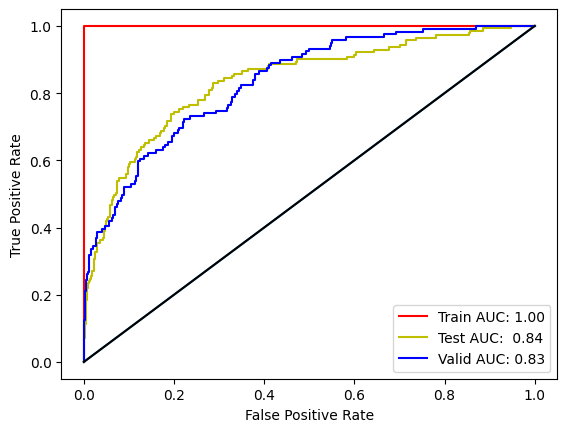

In [8]:
#Plot the ROC Curves - ensure to use the predicted probabilities and not the predicted values
auc_train = roc_auc_score(y_train, y_train_prob)
auc_test = roc_auc_score(y_test, y_test_prob)
auc_valid = roc_auc_score(y_valid, y_valid_prob)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_prob)

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_test, tpr_test,'y-', label =   'Test AUC:  %.2f'%auc_test)
plt.plot(fpr_valid, tpr_valid,'b-',label =  'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In the following section we will look at the learning curves for the model and then look to tune the model to increase its efficacy.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


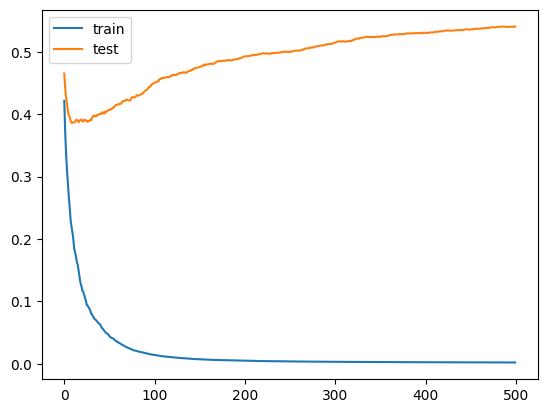

Accuracy: 83.63%


In [9]:
# plot learning curve of an XGBoost model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from matplotlib import pyplot

# define the model
model = XGBClassifier(n_estimators=500)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset, verbose=0)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print("Accuracy: %.2f%%" % (score * 100.0))

The plot shows learning curves for the train and test datasets where the x-axis is the number of iterations (or number of trees) of the algorithm while the y-axis is the logloss of the model. Each line shows the logloss per iteration for a given dataset.

From the learning curves, we can see that the performance of the model on the training dataset (blue line) is better (lower loss) than the performance of the model on the test dataset (orange line). This is an expected outcome though the shape of the test curve is of some concern. Let's see if we can improve the model through fine tuning of the hyperparameters.

Tuning the XGBoost model using learning curves

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


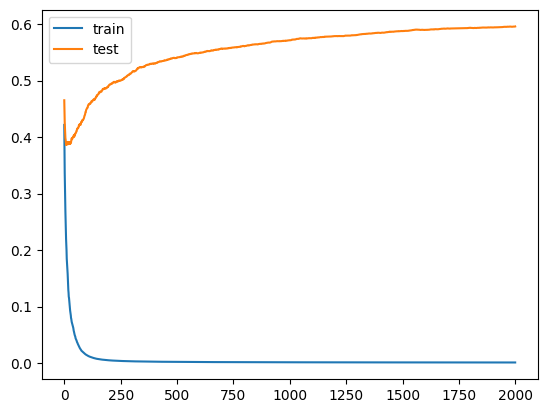

Accuracy: 83.19%


In [10]:
#Increasing the number of iterations
#This can be achieved by increasing the estimators variable.

# plot learning curve of an xgboost model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from matplotlib import pyplot

# define the model
model = XGBClassifier(n_estimators=2000)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset, verbose=0)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print("Accuracy: %.2f%%" % (score * 100.0))

Increasing the number of iterations appears to reduce the accuracy. Ideally we would want to see the difference between the logloss of the train and test data to converge and not increase. Perhaps if we maintain the 2000 iterations and adjust other hyperparameters, we may increase the accuracy of the model.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


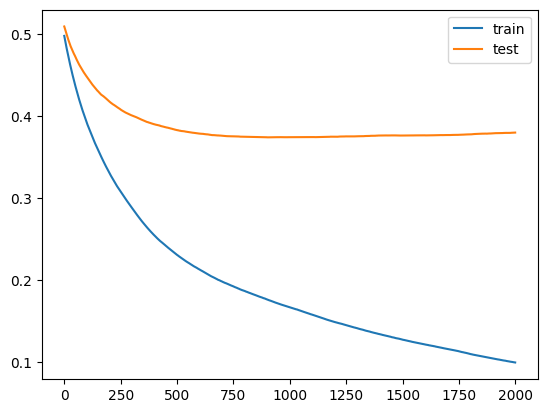

Accuracy: 83.77%


In [11]:
#Slowing down the learning rate
#This can be achieved using the learning rate, which limits the contribution of each tree added to the ensemble.
#This can be controlled via the “eta” hyperparameter and defaults to the value of 0.3. We can try a smaller value, such as 0.005.

# plot learning curve of an xgboost model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from matplotlib import pyplot

# define the model
model = XGBClassifier(n_estimators=2000, eta=0.005)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset, verbose=0)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print("Accuracy: %.2f%%" % (score * 100.0))

We see an increase in accuracy in this case to 83.77%.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


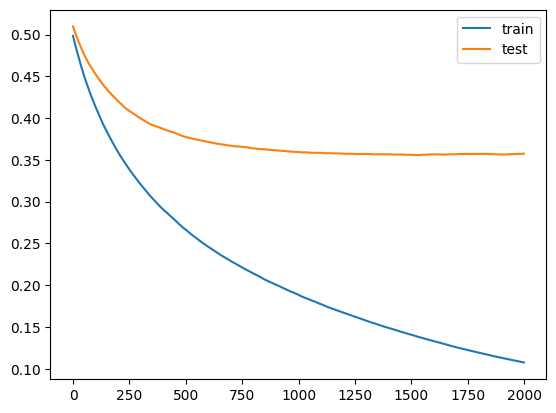

Accuracy: 85.09%


In [12]:
#Regularization
#Another approach to slowing down learning is to add regularization in the form of reducing the number of samples and features (rows and columns) used to construct each tree in the ensemble.

# plot learning curve of an xgboost model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from matplotlib import pyplot

# define the model
model = XGBClassifier(n_estimators=2000, eta=0.005, subsample=0.5, colsample_bytree=0.5)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset, verbose=0)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print("Accuracy: %.2f%%" % (score * 100.0))

We see an increase in accuracy in this case to 85.09%.

Feature Selection

Let's analyze which features from the dataset have the greatest importance to the model efficacy.
Note that given the process by which this part of the analysis is run, your results may differ than what is shown.

Text(0.5, 0, 'Permutation Importance')

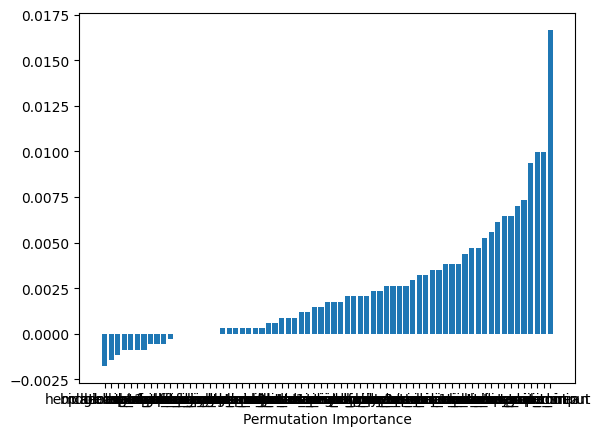

In [13]:
#Feature selection
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.bar(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


That chart is a bit messy. Let's look at the most important features

Text(0.5, 0, 'Permutation Importance')

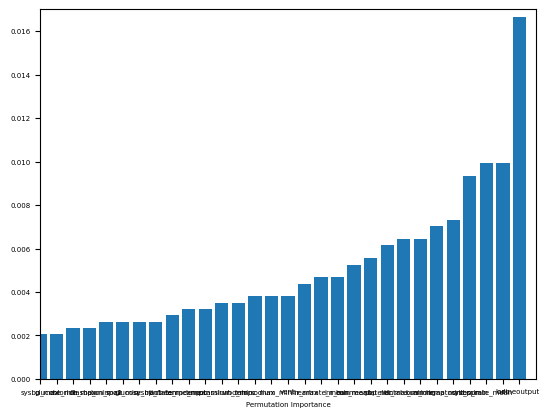

In [15]:
cutoff = 30
plt.rc('font', size=5)
plt.bar(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.ylim(0.000,0.017)
plt.xlim(len(sorted_idx)-cutoff,len(sorted_idx))
plt.xlabel("Permutation Importance")

Let's rerun the XGBoost analysis with our updated model and the condensed feature list

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Model AUC
Train AUC:         99.93%
Test AUC:          82.85%
Valid AUC:         83.94%

Model Accuracy
Train accuracy:    96.93%
Test accuracy:     84.06%
Valid accuracy:    86.55%

Recall: True Positive
Train Recall:      100.00%
Test Recall:       97.61%
Valid Recall:      96.64%

Specificity: True Negative
Train specificity: 84.42%
Test specificity:  31.91%
Valid specificity: 38.66%

Fall Out: False Positive
Train Fall Out:    15.58%
Test Fall Out:     68.09%
Valid Fall Out:    61.34%

Miss Rate: False Negative
Train specificity: 0.00%
Test specificity:  2.39%
Valid specificity: 3.36%

Precision: Positive Results Relative to Predicted Positive Results
Train precision:   96.32%
Test precision:    84.66%
Valid precision:   88.21%



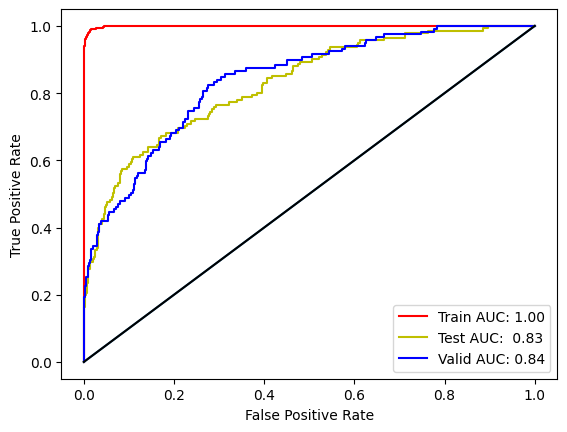

In [16]:
X_new = df_sepsis[X.columns[sorted_idx][len(sorted_idx)-cutoff:len(sorted_idx)]]
Y = df_sepsis[['thirtyday_expire_flag']]

#Split data into test and training sets
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=test_size, random_state=seed)

#Split test data equally into validation and test sets
X_valid = X_test.sample(frac = 0.5, random_state=seed)
X_test  = X_test.drop(X_valid.index)
y_valid = y_test.sample(frac = 0.5, random_state=seed)
y_test  = y_test.drop(y_valid.index)

#Train the model
# fit model on training data
model_XGB = XGBClassifier(n_estimators=2000, eta=0.005, subsample=0.5, colsample_bytree=0.5)
evalset = [(X_train, y_train), (X_test, y_test)]
model_XGB.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset, verbose=0)

#Make predictions using the XGBoost model

#For AUC, we need to predict the probabilities
y_train_prob  = model_XGB.predict_proba(X_train)[:,1]
y_test_prob   = model_XGB.predict_proba(X_test)[:,1]
y_valid_prob  = model_XGB.predict_proba(X_valid)[:,1]

print('Model AUC')
print('Train AUC:         %.2f%%'%(roc_auc_score(y_train, y_train_prob)*100))
print('Test AUC:          %.2f%%'%(roc_auc_score(y_test, y_test_prob)*100))
print('Valid AUC:         %.2f%%'%(roc_auc_score(y_valid.thirtyday_expire_flag, y_valid_prob)*100))
print('')

#for the following characteristics, we will use the multi-label confusion matrix which is used for evaluating the performance of a machine learning model.
#tn = True Negative; tp = True Positive; fn = False Negative; fp = False Positive

#For characteristics, we need to make predictions, not probabilities
y_test_preds  = model_XGB.predict(X_test)
y_train_preds = model_XGB.predict(X_train)
y_valid_preds = model_XGB.predict(X_valid)

print('Model Accuracy')
print('Train accuracy:    %.2f%%'%(calc_accuracy(y_train, y_train_preds)*100))
print('Test accuracy:     %.2f%%'%(calc_accuracy(y_test, y_test_preds)*100))
print('Valid accuracy:    %.2f%%'%(calc_accuracy(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

print('Recall: True Positive')
print('Train Recall:      %.2f%%'%(calc_recall(y_train.thirtyday_expire_flag, y_train_preds)*100))
print('Test Recall:       %.2f%%'%(calc_recall(y_test.thirtyday_expire_flag, y_test_preds)*100))
print('Valid Recall:      %.2f%%'%(calc_recall(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

print('Specificity: True Negative')
print('Train specificity: %.2f%%'%(calc_specificity(y_train.thirtyday_expire_flag, y_train_preds)*100))
print('Test specificity:  %.2f%%'%(calc_specificity(y_test.thirtyday_expire_flag, y_test_preds)*100))
print('Valid specificity: %.2f%%'%(calc_specificity(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

print('Fall Out: False Positive')
print('Train Fall Out:    %.2f%%'%(calc_fallout(y_train.thirtyday_expire_flag, y_train_preds)*100))
print('Test Fall Out:     %.2f%%'%(calc_fallout(y_test.thirtyday_expire_flag, y_test_preds)*100))
print('Valid Fall Out:    %.2f%%'%(calc_fallout(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

print('Miss Rate: False Negative')
print('Train specificity: %.2f%%'%(calc_missrate(y_train.thirtyday_expire_flag, y_train_preds)*100))
print('Test specificity:  %.2f%%'%(calc_missrate(y_test.thirtyday_expire_flag, y_test_preds)*100))
print('Valid specificity: %.2f%%'%(calc_missrate(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

print('Precision: Positive Results Relative to Predicted Positive Results')
print('Train precision:   %.2f%%'%(calc_precision(y_train, y_train_preds)*100))
print('Test precision:    %.2f%%'%(calc_precision(y_test, y_test_preds)*100))
print('Valid precision:   %.2f%%'%(calc_precision(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('')

#Plot the ROC Curves - ensure to use the predicted probabilities and not the predicted values
auc_train = roc_auc_score(y_train, y_train_prob)
auc_test = roc_auc_score(y_test, y_test_prob)
auc_valid = roc_auc_score(y_valid, y_valid_prob)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_prob)

plt.rc('font', size=10)
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_test, tpr_test,'y-', label =   'Test AUC:  %.2f'%auc_test)
plt.plot(fpr_valid, tpr_valid,'b-',label =  'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

We do see marginal increases in both model accuracy and AUC when using the updated XGBoost model using regularization, increase iterations, and a slower learning rate coupled with the updated feature list. We will use these results when comparing and seeking improvement using LightGBM and CatBoost.

Before doing so, we will run our model using the condensed feature list as defined in the research paper to see if the results are better than our own.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Model AUC
Train AUC:         98.89%
Test AUC:          81.80%
Valid AUC:         80.41%

Model Accuracy
Train accuracy:    94.42%
Test accuracy:     82.31%
Valid accuracy:    85.67%

Recall: True Positive
Train Recall:      99.96%
Test Recall:       95.58%
Valid Recall:      95.75%

Specificity: True Negative
Train specificity: 71.86%
Test specificity:  31.21%
Valid specificity: 37.82%

Fall Out: False Positive
Train Fall Out:    28.14%
Test Fall Out:     68.79%
Valid Fall Out:    62.18%

Miss Rate: False Negative
Train specificity: 0.04%
Test specificity:  4.42%
Valid specificity: 4.25%

Precision: Positive Results Relative to Predicted Positive Results
Train precision:   93.54%
Test precision:    84.25%
Valid precision:   87.97%



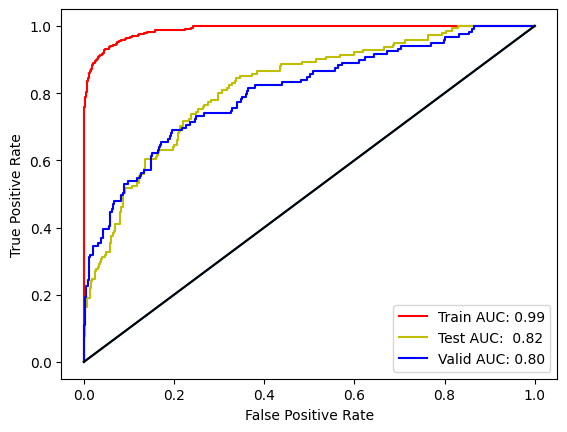

In [17]:
#pull the feature names from table 3 from the paper website
X_paper = df_sepsis[['urineoutput', 'lactate_min', 'bun_mean', 'sysbp_min', 'metastatic_cancer', 'inr_max', 'age', 'sodium_max', 'aniongap_max', 'creatinine_min', 'spo2_mean']]
Y_paper = df_sepsis[['thirtyday_expire_flag']]

#Split data into test and training sets
seed = 42
test_size = 0.30
X_train_paper, X_test_paper, y_train_paper, y_test_paper = train_test_split(X_paper, Y_paper, test_size=test_size, random_state=seed)

#Split test data equally into validation and test sets
X_valid_paper = X_test_paper.sample(frac = 0.5, random_state=seed)
X_test_paper  = X_test_paper.drop(X_valid.index)
y_valid_paper = y_test_paper.sample(frac = 0.5, random_state=seed)
y_test_paper  = y_test_paper.drop(y_valid.index)

#Train the model
# fit model on training data
model_XGB_paper = XGBClassifier(n_estimators=2000, eta=0.005) #, subsample=0.5, colsample_bytree=0.5)     #we are removing regularization given the small feature list
evalset_paper = [(X_train_paper, y_train_paper), (X_test_paper, y_test_paper)]
model_XGB_paper.fit(X_train_paper, y_train_paper, eval_metric='logloss', eval_set=evalset_paper, verbose=0)

#Make predictions using the XGBoost model

#For AUC, we need to predict the probabilities
y_train_paper_prob  = model_XGB_paper.predict_proba(X_train_paper)[:,1]
y_test_paper_prob   = model_XGB_paper.predict_proba(X_test_paper)[:,1]
y_valid_paper_prob  = model_XGB_paper.predict_proba(X_valid_paper)[:,1]

print('Model AUC')
print('Train AUC:         %.2f%%'%(roc_auc_score(y_train_paper, y_train_paper_prob)*100))
print('Test AUC:          %.2f%%'%(roc_auc_score(y_test_paper, y_test_paper_prob)*100))
print('Valid AUC:         %.2f%%'%(roc_auc_score(y_valid_paper.thirtyday_expire_flag, y_valid_paper_prob)*100))
print('')

#for the following characteristics, we will use the multi-label confusion matrix which is used for evaluating the performance of a machine learning model.
#tn = True Negative; tp = True Positive; fn = False Negative; fp = False Positive

#For characteristics, we need to make predictions, not probabilities
y_test_paper_preds  = model_XGB_paper.predict(X_test_paper)
y_train_paper_preds = model_XGB_paper.predict(X_train_paper)
y_valid_paper_preds = model_XGB_paper.predict(X_valid_paper)

print('Model Accuracy')
print('Train accuracy:    %.2f%%'%(calc_accuracy(y_train_paper, y_train_paper_preds)*100))
print('Test accuracy:     %.2f%%'%(calc_accuracy(y_test_paper, y_test_paper_preds)*100))
print('Valid accuracy:    %.2f%%'%(calc_accuracy(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds)*100))
print('')

print('Recall: True Positive')
print('Train Recall:      %.2f%%'%(calc_recall(y_train_paper.thirtyday_expire_flag, y_train_paper_preds)*100))
print('Test Recall:       %.2f%%'%(calc_recall(y_test_paper.thirtyday_expire_flag, y_test_paper_preds)*100))
print('Valid Recall:      %.2f%%'%(calc_recall(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds)*100))
print('')

print('Specificity: True Negative')
print('Train specificity: %.2f%%'%(calc_specificity(y_train_paper.thirtyday_expire_flag, y_train_paper_preds)*100))
print('Test specificity:  %.2f%%'%(calc_specificity(y_test_paper.thirtyday_expire_flag, y_test_paper_preds)*100))
print('Valid specificity: %.2f%%'%(calc_specificity(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds)*100))
print('')

print('Fall Out: False Positive')
print('Train Fall Out:    %.2f%%'%(calc_fallout(y_train_paper.thirtyday_expire_flag, y_train_paper_preds)*100))
print('Test Fall Out:     %.2f%%'%(calc_fallout(y_test_paper.thirtyday_expire_flag, y_test_paper_preds)*100))
print('Valid Fall Out:    %.2f%%'%(calc_fallout(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds)*100))
print('')

print('Miss Rate: False Negative')
print('Train specificity: %.2f%%'%(calc_missrate(y_train_paper.thirtyday_expire_flag, y_train_paper_preds)*100))
print('Test specificity:  %.2f%%'%(calc_missrate(y_test_paper.thirtyday_expire_flag, y_test_paper_preds)*100))
print('Valid specificity: %.2f%%'%(calc_missrate(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds)*100))
print('')

print('Precision: Positive Results Relative to Predicted Positive Results')
print('Train precision:   %.2f%%'%(calc_precision(y_train_paper, y_train_paper_preds)*100))
print('Test precision:    %.2f%%'%(calc_precision(y_test_paper, y_test_paper_preds)*100))
print('Valid precision:   %.2f%%'%(calc_precision(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds)*100))
print('')

#Plot the ROC Curves - ensure to use the predicted probabilities and not the predicted values
auc_train_paper = roc_auc_score(y_train_paper, y_train_paper_prob)
auc_test_paper = roc_auc_score(y_test_paper, y_test_paper_prob)
auc_valid_paper = roc_auc_score(y_valid_paper, y_valid_paper_prob)

fpr_train_paper, tpr_train_paper, thresholds_train_paper = roc_curve(y_train_paper, y_train_paper_prob)
fpr_test_paper, tpr_test_paper, thresholds_test_paper = roc_curve(y_test_paper, y_test_paper_prob)
fpr_valid_paper, tpr_valid_paper, thresholds_valid_paper = roc_curve(y_valid_paper, y_valid_paper_prob)

plt.rc('font', size=10)
plt.plot(fpr_train_paper, tpr_train_paper,'r-', label = 'Train AUC: %.2f'%auc_train_paper)
plt.plot(fpr_test_paper, tpr_test_paper,'y-', label =   'Test AUC:  %.2f'%auc_test_paper)
plt.plot(fpr_valid_paper, tpr_valid_paper,'b-',label =  'Valid AUC: %.2f'%auc_valid_paper)
plt.plot([0,1],[0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [18]:
#Compare the model using the research paper features vs our own set of features
print('Model AUC')
print('Research Paper Model:    %.2f%%'%(roc_auc_score(y_valid_paper, y_valid_paper_prob)*100))
print('Our Tuned Model:         %.2f%%'%(roc_auc_score(y_valid, y_valid_prob)*100))
print('')

print('Model Accuracy')
print('Research Paper Model:    %.2f%%'%(calc_accuracy(y_valid_paper, y_valid_paper_preds)*100))
print('Our Tuned Model:         %.2f%%'%(calc_accuracy(y_valid, y_valid_preds)*100))
print('')


Model AUC
Research Paper Model:    80.41%
Our Tuned Model:         83.94%

Model Accuracy
Research Paper Model:    85.67%
Our Tuned Model:         86.55%



Our tuned model produces results that show improvement relative to the research model paper. However, we will use the feature list from the research paper for comparison's sake as we are looking to show improved performance relative to the paper's results and keep our custom feature dataset (X_new) for potential future use.

##Sepsis 30-day mortality prediction using LightGBM

Light Gradient Boosted Machine, or LightGBM for short, is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm.

LightGBM extends the gradient boosting algorithm by adding a type of automatic feature selection as well as focusing on boosting examples with larger gradients. This can result in a dramatic speedup of training and improved predictive performance.

In [19]:
!pip install lightgbm

In [20]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

#Define the model
model_LGBM = LGBMClassifier()

#Using the feature mapping from the research paper: "X_paper" and the same target/output "Y_paper"
#fit the model on the same training data we used in the updated XGBoost model
model_LGBM.fit(X_train_paper, y_train_paper)

#We will evaluate the model using repeated stratified k-fold cross-validation with three repeats and 10 folds.
#We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.
#evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_LGBM, X_paper, Y_paper, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('')
print('Accuracy: %.2f%%' % (mean(n_scores)*100))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 629, number of negative: 2562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 3191, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197117 -> initscore=-1.404412
[LightGBM] [Info] Start training from score -1.404412

Accuracy: 83.67%


The model using default hyperparameters reports an accuracy of 83.67% which is below that for the XGBoost model using the research paper features (85.67%) and below our tuned XGBoost model using our own feature list (86.55%).

Let's see if we can adjust some parameters to improve its accuracy.

# of Trees: 10 83.68%)
# of Trees: 100 83.67%)
# of Trees: 500 83.14%)
# of Trees: 1000 83.21%)
# of Trees: 5000 83.16%)


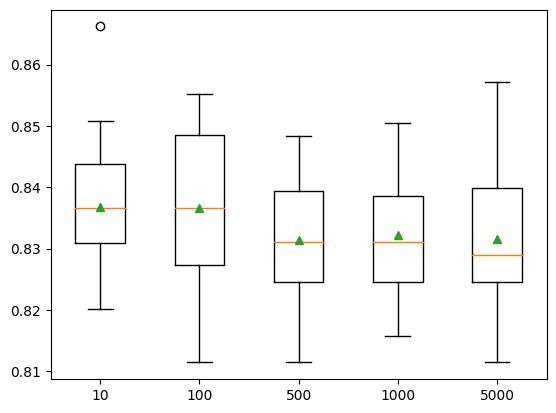

In [21]:
#Tuning the LightGBM model: Increasing the number of trees

#create a list of models using various numbers of trees
def get_models():
  models = dict()
  trees = [10, 100, 500, 1000, 5000]
  for i in trees:
    models[str(i)] = LGBMClassifier(n_estimators=i)
  return models

#evaluate a given model using cross-validation
def evaluate_model(model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X_paper, Y_paper, scoring='accuracy', cv=cv, n_jobs=-1)
  return scores

#get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model)
  results.append(scores)
  names.append(name)
  print('# of Trees: %s %.2f%%)' % (name, mean(scores)*100))

#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

We do not see any improvement in increasing the number of trees over the default of 100 trees and in fact see an ever so slight increase in efficacy in less trees. However, given the shape of the box-and-whisker plot, we will maintain the default of 100 going forward.

Next let's experiment with the tree depth: The tree depth controls how specialized each tree is to the training dataset or how general or overfit it might be.

Tree Depth: 1 84.20%)
Tree Depth: 2 84.48%)
Tree Depth: 3 84.35%)
Tree Depth: 4 84.22%)
Tree Depth: 5 83.98%)
Tree Depth: 6 83.77%)
Tree Depth: 7 84.03%)
Tree Depth: 8 84.02%)
Tree Depth: 9 84.00%)
Tree Depth: 10 83.86%)


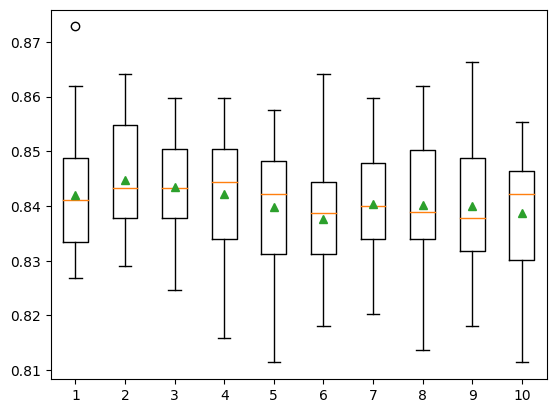

In [22]:
#Tuning the LightGBM model: Adjusting the tree depth

#create a list of models using various depths of trees
def get_models():
  models = dict()
  for i in range(1,11):
    models[str(i)] = LGBMClassifier(max_depth=i, num_leaves=2**i)
  return models

#evaluate a given model using cross-validation
def evaluate_model(model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X_paper, Y_paper, scoring='accuracy', cv=cv, n_jobs=-1)
  return scores

#get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model)
  results.append(scores)
  names.append(name)
  print('Tree Depth: %s %.2f%%)' % (name, mean(scores)*100))

#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

We see the accuracy peak at a tree depth of 2 and will use this going forward.

Now let's experiment with the learning rate, similar to as we did for XGBoost.

Learning Rate: 0.0001 80.50%)
Learning Rate: 0.0010 80.50%)
Learning Rate: 0.0100 81.87%)
Learning Rate: 0.1000 84.48%)
Learning Rate: 0.2500 84.10%)
Learning Rate: 0.5000 83.42%)
Learning Rate: 1.0000 81.88%)


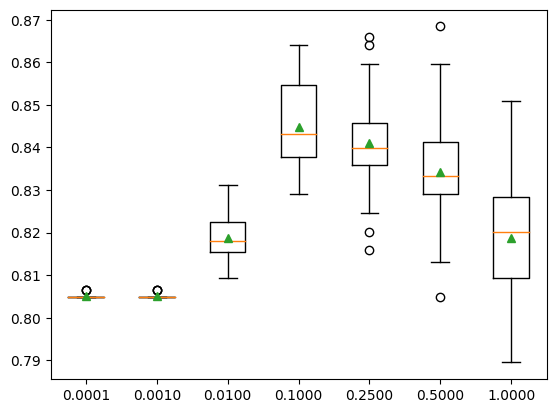

In [23]:
#Tuning the LightGBM model: Adjusting the learning rate

#create a list of models using various learning rates
def get_models():
  models = dict()
  rates = [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 1.0]
  for r in rates:
    key = '%.4f' % r
    models[key] = LGBMClassifier(max_depth=2, num_leaves=4,learning_rate=r)
  return models

#evaluate a given model using cross-validation
def evaluate_model(model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X_paper, Y_paper, scoring='accuracy', cv=cv, n_jobs=-1)
  return scores

#get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model)
  results.append(scores)
  names.append(name)
  print('Learning Rate: %s %.2f%%)' % (name, mean(scores)*100))

#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

We see the accuracy peak at a learning rate of 0.10 and will use this level in future analysis.

Now let's try tuning the model based on different boosting methods contained in LightGBM.

Boosting Type: gbdt 84.48%)
Boosting Type: dart 84.24%)
Boosting Type: goss 84.59%)


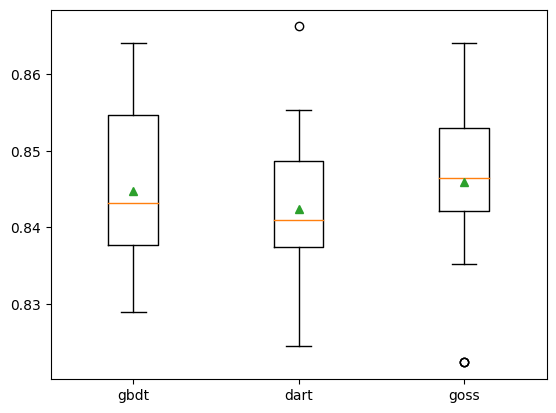

In [24]:
#Tuning the LightGBM model: Adjusting the Boosting algorithm
#LightGBM includes three different boosting algorithms which we will assess in our model
#gbdt: Gradient Boosting Decision Tree (GDBT)
#dart: Dropouts meet Multiple Additive Regression Trees (DART)
#goss: Gradient-based One-Side Sampling (GOSS)

#create a list of models using various boosting algorithms
def get_models():
  models = dict()
  types = ['gbdt', 'dart', 'goss']
  for t in types:
    models[t] = LGBMClassifier(max_depth=2, num_leaves=4,learning_rate=0.10, boosting_type=t)
  return models

#evaluate a given model using cross-validation
def evaluate_model(model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X_paper, Y_paper, scoring='accuracy', cv=cv, n_jobs=-1)
  return scores

#get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model)
  results.append(scores)
  names.append(name)
  print('Boosting Type: %s %.2f%%)' % (name, mean(scores)*100))

#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

We see a slight improvement using GOSS.
Now we have our tuned LightGBM model using 100 trees, a depth of 2, a learning rate of 0.10, and boosting algorithm GOSS.

Let's run similar characteristics on this model as we did for XGBoost.

In [26]:
#Define the model
model_LGBM = LGBMClassifier(max_depth=2, num_leaves=4,learning_rate=0.10, boosting_type='dart')

#fit the model
model_LGBM.fit(X_train_paper, y_train_paper)

#Make predictions using the LGBM model
#For AUC, we need to predict the probabilities
y_train_prob_LGBM  = model_LGBM.predict_proba(X_train_paper)[:,1]
y_test_prob_LGBM   = model_LGBM.predict_proba(X_test_paper)[:,1]
y_valid_prob_LGBM  = model_LGBM.predict_proba(X_valid_paper)[:,1]

print('Model AUC')
print('Train AUC:         %.2f%%'%(roc_auc_score(y_train_paper, y_train_prob_LGBM)*100))
print('Test AUC:          %.2f%%'%(roc_auc_score(y_test_paper, y_test_prob_LGBM)*100))
print('Valid AUC:         %.2f%%'%(roc_auc_score(y_valid_paper.thirtyday_expire_flag, y_valid_prob_LGBM)*100))
print('')

#For characteristics, we need to make predictions, not probabilities
y_test_preds_LGBM = model_LGBM.predict(X_test_paper)
y_train_preds_LGBM = model_LGBM.predict(X_train_paper)
y_valid_preds_LGBM = model_LGBM.predict(X_valid_paper)

print('Model Accuracy')
print('Train accuracy:    %.2f%%'%(calc_accuracy(y_train_paper, y_train_preds_LGBM)*100))
print('Test accuracy:     %.2f%%'%(calc_accuracy(y_test_paper, y_test_preds_LGBM)*100))
print('Valid accuracy:    %.2f%%'%(calc_accuracy(y_valid_paper.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('')

print('Recall: True Positive')
print('Train Recall:      %.2f%%'%(calc_recall(y_train_paper.thirtyday_expire_flag, y_train_preds_LGBM)*100))
print('Test Recall:       %.2f%%'%(calc_recall(y_test_paper.thirtyday_expire_flag, y_test_preds_LGBM)*100))
print('Valid Recall:      %.2f%%'%(calc_recall(y_valid_paper.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('')

print('Specificity: True Negative')
print('Train specificity: %.2f%%'%(calc_specificity(y_train_paper.thirtyday_expire_flag, y_train_preds_LGBM)*100))
print('Test specificity:  %.2f%%'%(calc_specificity(y_test_paper.thirtyday_expire_flag, y_test_preds_LGBM)*100))
print('Valid specificity: %.2f%%'%(calc_specificity(y_valid_paper.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('')

print('Fall Out: False Positive')
print('Train Fall Out:    %.2f%%'%(calc_fallout(y_train_paper.thirtyday_expire_flag, y_train_preds_LGBM)*100))
print('Test Fall Out:     %.2f%%'%(calc_fallout(y_test_paper.thirtyday_expire_flag, y_test_preds_LGBM)*100))
print('Valid Fall Out:    %.2f%%'%(calc_fallout(y_valid_paper.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('')

print('Miss Rate: False Negative')
print('Train specificity: %.2f%%'%(calc_missrate(y_train_paper.thirtyday_expire_flag, y_train_preds_LGBM)*100))
print('Test specificity:  %.2f%%'%(calc_missrate(y_test_paper.thirtyday_expire_flag, y_test_preds_LGBM)*100))
print('Valid specificity: %.2f%%'%(calc_missrate(y_valid_paper.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('')

print('Precision: Positive Results Relative to Predicted Positive Results')
print('Train precision:   %.2f%%'%(calc_precision(y_train_paper, y_train_preds_LGBM)*100))
print('Test precision:    %.2f%%'%(calc_precision(y_test_paper, y_test_preds_LGBM)*100))
print('Valid precision:   %.2f%%'%(calc_precision(y_valid_paper.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 629, number of negative: 2562
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 3191, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197117 -> initscore=-1.404412
[LightGBM] [Info] Start training from score -1.404412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model AUC
Train AUC:         82.87%
Test AUC:          80.86%
Valid AUC:         81.66%

Model Accuracy
Train accuracy:    84.42%
Test accuracy:     84.06%
Valid accuracy:    87.13%

Recall: True Positive
Train Recall:      98.79%
Test Recall:       99.45%
Valid Recall:      98.94%

S

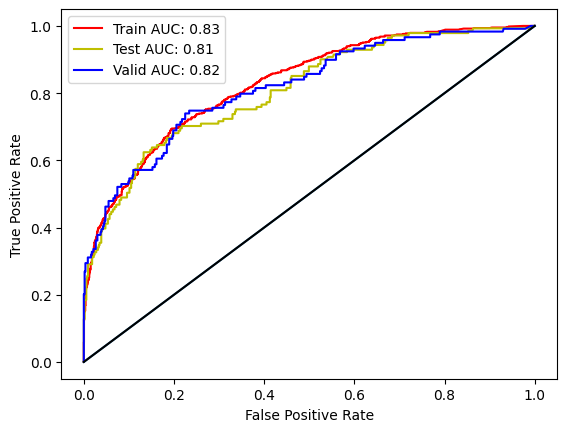

In [27]:
#Plot the ROC Curves - ensure to use the predicted probabilities and not the predicted values
auc_train_LGBM = roc_auc_score(y_train_paper, y_train_prob_LGBM)
auc_test_LGBM = roc_auc_score(y_test_paper, y_test_prob_LGBM)
auc_valid_LGBM = roc_auc_score(y_valid_paper, y_valid_prob_LGBM)

fpr_train_LGBM, tpr_train_LGBM, thresholds_train_LGBM = roc_curve(y_train_paper, y_train_prob_LGBM)
fpr_test_LGBM, tpr_test_LGBM, thresholds_test_LGBM = roc_curve(y_test_paper, y_test_prob_LGBM)
fpr_valid_LGBM, tpr_valid_LGBM, thresholds_valid_LGBM = roc_curve(y_valid_paper, y_valid_prob_LGBM)

plt.plot(fpr_train_LGBM, tpr_train_LGBM,'r-', label = 'Train AUC: %.2f'%auc_train_LGBM)
plt.plot(fpr_test_LGBM, tpr_test_LGBM,'y-', label = 'Test AUC: %.2f'%auc_test_LGBM)
plt.plot(fpr_valid_LGBM, tpr_valid_LGBM,'b-',label = 'Valid AUC: %.2f'%auc_valid_LGBM)
plt.plot([0,1],[0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [28]:
#Compare the LightGBM model using the research paper features vs XGBoost Models using both the research paper features and our own set of features
print('Model AUC')
print('XGBoost Research Paper Model:      %.2f%%'%(roc_auc_score(y_valid_paper, y_valid_paper_prob)*100))
print('XGBoost Our Tuned Model:           %.2f%%'%(roc_auc_score(y_valid, y_valid_prob)*100))
print('LightGBM Research Paper Model:     %.2f%%'%(roc_auc_score(y_valid_paper.thirtyday_expire_flag, y_valid_prob_LGBM)*100))
print('')

print('Model Accuracy')
print('XGBoost Research Paper Model:      %.2f%%'%(calc_accuracy(y_valid_paper, y_valid_paper_preds)*100))
print('XGBoost Our Tuned Model:           %.2f%%'%(calc_accuracy(y_valid, y_valid_preds)*100))
print('LightGBM Research Paper Model:     %.2f%%'%(calc_accuracy(y_valid_paper.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('')


Model AUC
XGBoost Research Paper Model:      80.41%
XGBoost Our Tuned Model:           83.94%
LightGBM Research Paper Model:     81.66%

Model Accuracy
XGBoost Research Paper Model:      85.67%
XGBoost Our Tuned Model:           86.55%
LightGBM Research Paper Model:     87.13%



We see an increase in both AUC and Accuracy when comparing these results to the XGBoost model using the research paper features.

We also see an increase in model accuracy but a decrease in AUC when using the LightGBM model relative to the XGBoost model using our tuned model features.

We will use these LightGBM results when comparing and seeking improvement using CatBoost.

##Sepsis 30-day mortality prediction using CatBoost

CatBoost is a third-party library developed at Yandex that provides an efficient implementation of the gradient boosting algorithm. Certain academic papers have pointed to CatBoost's ability to outperform other gradient boosting algorithms such as XGBoost and LightGBM.


In [29]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.8 MB/s eta 0:00:00


In [30]:
import catboost as catb
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

#Define the model
model_CATB = CatBoostClassifier(verbose=0)

#Using the feature mapping from the research paper: "X_paper" and the same target/output "Y_paper"
#fit the model on the same training data we used in the updated XGBoost model
model_CATB.fit(X_train_paper, y_train_paper)

#We will evaluate the model using the same structure as that for LightGBM:
#Repeated stratified k-fold cross-validation with three repeats and 10 folds.
#We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.
#evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_CATB, X_paper, Y_paper, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.2f%%' % (mean(n_scores)*100))

Accuracy: 84.40%


The model using default hyperparameters reports an accuracy of 84.40% which is below that for the XGBoost model using the research paper features (85.67%), below the tuned XGBoost model using our feature list (86.55%), and below our tuned LightGBM model using the research paper feature list (87.13%).

Similar to the LightGBM approach, let's finetune the hyperparameters to see if we can increase the model accuracy.

# of Iterations: 100 84.62%)
# of Iterations: 500 84.39%)
# of Iterations: 1000 84.40%)
# of Iterations: 5000 84.32%)


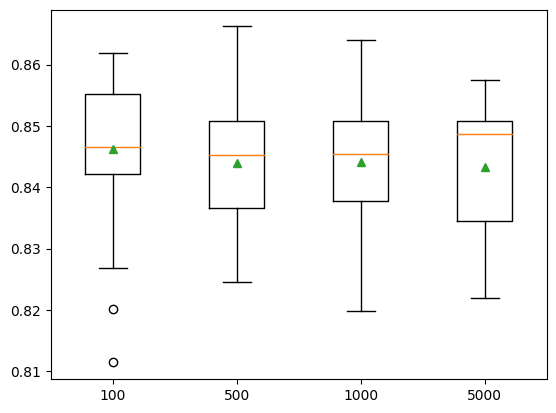

In [31]:
#Tuning the CatBoost model: Increasing the number of model iterations - this may take some time to run

#create a list of models using various numbers of iterations
def get_models():
  models = dict()
  iters = [100, 500, 1000, 5000]
  for i in iters:
    models[str(i)] = CatBoostClassifier(iterations=i, verbose=0)
  return models

#evaluate a given model using cross-validation
def evaluate_model(model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X_paper, Y_paper, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  return scores

#get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model)
  results.append(scores)
  names.append(name)
  print('# of Iterations: %s %.2f%%)' % (name, mean(scores)*100))

#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

We do not see any improvement in increasing the number of iterations over 100 and will use this value going forward.

Tree Depth: 1 84.43%)
Tree Depth: 2 84.66%)
Tree Depth: 3 84.46%)
Tree Depth: 4 84.63%)
Tree Depth: 5 84.79%)
Tree Depth: 6 84.62%)
Tree Depth: 7 84.64%)
Tree Depth: 8 84.70%)
Tree Depth: 9 84.74%)
Tree Depth: 10 84.49%)


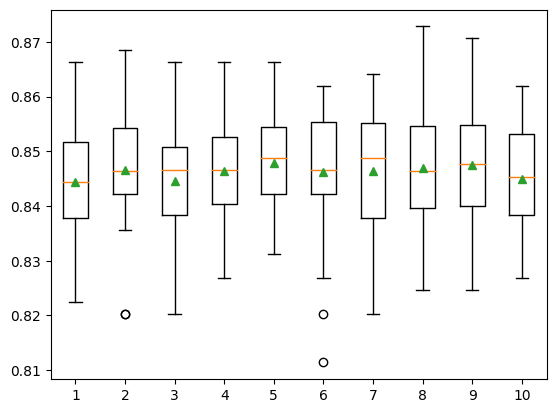

In [32]:
#Tuning the CatBoost model: Adjusting the tree depth - this too will take some time to run

#create a list of models using various depths of trees
def get_models():
  models = dict()
  for i in range(1,11):
    models[str(i)] = CatBoostClassifier(depth=i, iterations=100, verbose=0)
  return models

#evaluate a given model using cross-validation
def evaluate_model(model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X_paper, Y_paper, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  return scores

#get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model)
  results.append(scores)
  names.append(name)
  print('Tree Depth: %s %.2f%%)' % (name, mean(scores)*100))

#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Accuracy peaks at a depth of 5 which we will use going forward.

Learning Rate: 0.0010 83.02%)
Learning Rate: 0.0100 83.45%)
Learning Rate: 0.1000 84.62%)
Learning Rate: 0.2500 84.43%)
Learning Rate: 0.5000 83.59%)
Learning Rate: 1.0000 82.25%)


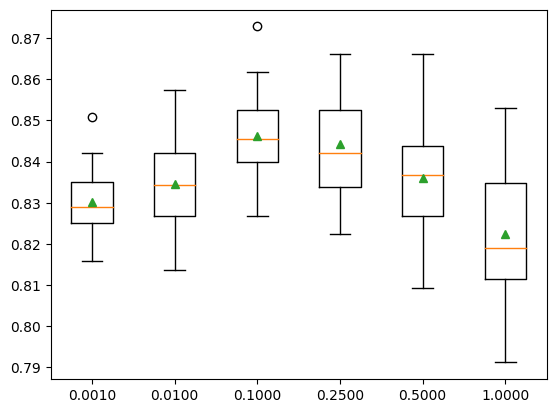

In [33]:
#Tuning the CatBoost model: Adjusting the learning rate

#create a list of models using various learning rates
def get_models():
  models = dict()
  rates = [0.001, 0.01, 0.1, 0.25, 0.5, 1.0]
  for r in rates:
    key = '%.4f' % r
    models[key] = CatBoostClassifier(learning_rate=r, depth=5, iterations=100, verbose=0)
  return models

#evaluate a given model using cross-validation
def evaluate_model(model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X_paper, Y_paper, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  return scores

#get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model)
  results.append(scores)
  names.append(name)
  print('Learning Rate: %s %.2f%%)' % (name, mean(scores)*100))

#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

We see the accuracy peak at a learning rate of 0.10 and will use this level in future analysis.

Bootstrap Type: Bayesian 84.75%)
Bootstrap Type: Bernoulli 84.78%)
Bootstrap Type: MVS 84.62%)


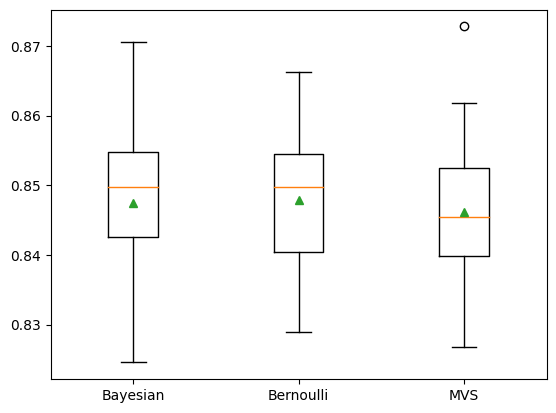

In [34]:
#Tuning the CatBoost model: adjusting the Bootstrap type: this parameter can serve to implement regularization and improve speed
#CatBoost includes four different bootstrap methods which we will assess in our model
#Bayesian
#Bernoulli
#MVS
#Poisson (supported for GPU only so will exclude from this analysis)

#create a list of models using various numbers of trees incorporating depth from previous example
def get_models():
  models = dict()
  types = ['Bayesian', 'Bernoulli', 'MVS']
  for t in types:
    models[t] = CatBoostClassifier(bootstrap_type=t, learning_rate=0.10, depth=5, iterations=100, verbose=0)
  return models

#evaluate a given model using cross-validation
def evaluate_model(model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X_paper, Y_paper, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  return scores

#get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model)
  results.append(scores)
  names.append(name)
  print('Bootstrap Type: %s %.2f%%)' % (name, mean(scores)*100))

#plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

We will use the Bernouli bootstrap method given its highest accuracy, higher than the prior parameter run using the default.

Now we have our tuned CatBoost model using 100 iterations, a depth of 5, a learning rate of 0.10, and the Bernoulli bootstrap algorithm.

In [35]:
#Define the model
model_CATB = CatBoostClassifier(bootstrap_type='Bernoulli', learning_rate=0.10, depth=5, iterations=100, verbose=0)

#fit the model
model_CATB.fit(X_train_paper, y_train_paper)

#Make predictions using the CATB model
#For AUC, we need to predict the probabilities
y_train_paper_prob_CATB  = model_CATB.predict_proba(X_train_paper)[:,1]
y_test_paper_prob_CATB   = model_CATB.predict_proba(X_test_paper)[:,1]
y_valid_paper_prob_CATB  = model_CATB.predict_proba(X_valid_paper)[:,1]

print('Model AUC')
print('Train AUC:         %.2f%%'%(roc_auc_score(y_train_paper, y_train_paper_prob_CATB)*100))
print('Test AUC:          %.2f%%'%(roc_auc_score(y_test_paper, y_test_paper_prob_CATB)*100))
print('Valid AUC:         %.2f%%'%(roc_auc_score(y_valid_paper.thirtyday_expire_flag, y_valid_paper_prob_CATB)*100))
print('')

#For characteristics, we need to make predictions, not probabilities
y_test_paper_preds_CATB = model_CATB.predict(X_test_paper)
y_train_paper_preds_CATB = model_CATB.predict(X_train_paper)
y_valid_paper_preds_CATB = model_CATB.predict(X_valid_paper)

print('Model Accuracy')
print('Train accuracy:    %.2f%%'%(calc_accuracy(y_train_paper, y_train_paper_preds_CATB)*100))
print('Test accuracy:     %.2f%%'%(calc_accuracy(y_test_paper, y_test_paper_preds_CATB)*100))
print('Valid accuracy:    %.2f%%'%(calc_accuracy(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('')

print('Recall: True Positive')
print('Train Recall:      %.2f%%'%(calc_recall(y_train_paper.thirtyday_expire_flag, y_train_paper_preds_CATB)*100))
print('Test Recall:       %.2f%%'%(calc_recall(y_test_paper.thirtyday_expire_flag, y_test_paper_preds_CATB)*100))
print('Valid Recall:      %.2f%%'%(calc_recall(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('')

print('Specificity: True Negative')
print('Train specificity: %.2f%%'%(calc_specificity(y_train_paper.thirtyday_expire_flag, y_train_paper_preds_CATB)*100))
print('Test specificity:  %.2f%%'%(calc_specificity(y_test_paper.thirtyday_expire_flag, y_test_paper_preds_CATB)*100))
print('Valid specificity: %.2f%%'%(calc_specificity(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('')

print('Fall Out: False Positive')
print('Train Fall Out:    %.2f%%'%(calc_fallout(y_train_paper.thirtyday_expire_flag, y_train_paper_preds_CATB)*100))
print('Test Fall Out:     %.2f%%'%(calc_fallout(y_test_paper.thirtyday_expire_flag, y_test_paper_preds_CATB)*100))
print('Valid Fall Out:    %.2f%%'%(calc_fallout(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('')

print('Miss Rate: False Negative')
print('Train specificity: %.2f%%'%(calc_missrate(y_train_paper.thirtyday_expire_flag, y_train_paper_preds_CATB)*100))
print('Test specificity:  %.2f%%'%(calc_missrate(y_test_paper.thirtyday_expire_flag, y_test_paper_preds_CATB)*100))
print('Valid specificity: %.2f%%'%(calc_missrate(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('')

print('Precision: Positive Results Relative to Predicted Positive Results')
print('Train precision:   %.2f%%'%(calc_precision(y_train_paper, y_train_paper_preds_CATB)*100))
print('Test precision:    %.2f%%'%(calc_precision(y_test_paper, y_test_paper_preds_CATB)*100))
print('Valid precision:   %.2f%%'%(calc_precision(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('')

Model AUC
Train AUC:         86.59%
Test AUC:          83.00%
Valid AUC:         83.79%

Model Accuracy
Train accuracy:    86.18%
Test accuracy:     84.50%
Valid accuracy:    87.13%

Recall: True Positive
Train Recall:      98.44%
Test Recall:       97.97%
Valid Recall:      97.70%

Specificity: True Negative
Train specificity: 36.25%
Test specificity:  32.62%
Valid specificity: 36.97%

Fall Out: False Positive
Train Fall Out:    63.75%
Test Fall Out:     67.38%
Valid Fall Out:    63.03%

Miss Rate: False Negative
Train specificity: 1.56%
Test specificity:  2.03%
Valid specificity: 2.30%

Precision: Positive Results Relative to Predicted Positive Results
Train precision:   86.28%
Test precision:    84.85%
Valid precision:   88.04%



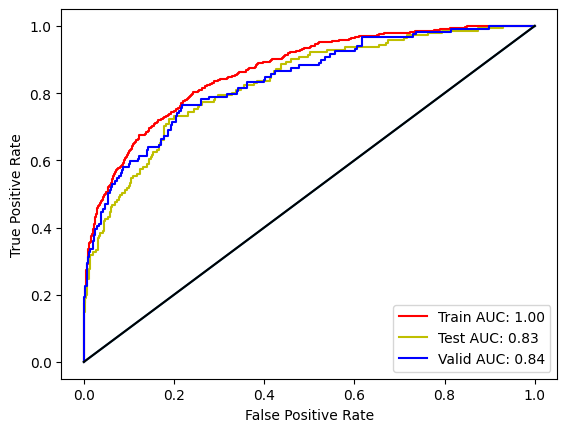

In [36]:
#Plot the ROC Curves - ensure to use the predicted probabilities and not the predicted values
auc_train_paper = roc_auc_score(y_train_paper, y_train_paper_prob_CATB)
auc_test_paper = roc_auc_score(y_test_paper, y_test_paper_prob_CATB)
auc_valid_paper = roc_auc_score(y_valid_paper, y_valid_paper_prob_CATB)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_paper, y_train_paper_prob_CATB)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_paper, y_test_paper_prob_CATB)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid_paper, y_valid_paper_prob_CATB)

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_test, tpr_test,'y-', label = 'Test AUC: %.2f'%auc_test)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [37]:
#Compare the CatBoost model using the research paper features vs XGBoost Models using both the research paper features and our own set of features along with LightGBM using the research paper features.
print('Model AUC')
print('XGBoost Research Paper Model:      %.2f%%'%(roc_auc_score(y_valid_paper, y_valid_paper_prob)*100))
print('XGBoost Our Tuned Model:           %.2f%%'%(roc_auc_score(y_valid, y_valid_prob)*100))
print('LightGBM Research Paper Model:     %.2f%%'%(roc_auc_score(y_valid_paper.thirtyday_expire_flag, y_valid_prob_LGBM)*100))
print('CatBoost Research Paper Model:     %.2f%%'%(roc_auc_score(y_valid_paper.thirtyday_expire_flag, y_valid_paper_prob_CATB)*100))
print('')

print('Model Accuracy')
print('XGBoost Research Paper Model:      %.2f%%'%(calc_accuracy(y_valid_paper, y_valid_paper_preds)*100))
print('XGBoost Our Tuned Model:           %.2f%%'%(calc_accuracy(y_valid, y_valid_preds)*100))
print('LightGBM Research Paper Model:     %.2f%%'%(calc_accuracy(y_valid_paper.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('CatBoost Research Paper Model:     %.2f%%'%(calc_accuracy(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('')


Model AUC
XGBoost Research Paper Model:      80.41%
XGBoost Our Tuned Model:           83.94%
LightGBM Research Paper Model:     81.66%
CatBoost Research Paper Model:     83.79%

Model Accuracy
XGBoost Research Paper Model:      85.67%
XGBoost Our Tuned Model:           86.55%
LightGBM Research Paper Model:     87.13%
CatBoost Research Paper Model:     87.13%



We see an increase in both AUC and Accuracy when comparing these results to the XGBoost model using the research paper features.

We also see an increase in both AUC and Accuracy when comparing these results to the XGBoost model using our tuned model features.

The CatBoost model also produces a higher AUC and inline Accuracy as the LightGBM model using the research paper features.


For comparison, let's run the parameterized CatBoost model based on our own custom features to compare to that for the features based on the research paper.

In [38]:
#Define the model
X_new = df_sepsis[X.columns[sorted_idx][len(sorted_idx)-cutoff:len(sorted_idx)]]
Y = df_sepsis[['thirtyday_expire_flag']]

#Split data into test and training sets
seed = 42
test_size = 0.30
X_cust_train, X_cust_test, y_cust_train, y_cust_test = train_test_split(X_new, Y, test_size=test_size, random_state=seed)

#Split test data equally into validation and test sets
X_cust_valid = X_cust_test.sample(frac = 0.5, random_state=seed)
X_cust_test  = X_cust_test.drop(X_cust_valid.index)
y_cust_valid = y_cust_test.sample(frac = 0.5, random_state=seed)
y_cust_test  = y_cust_test.drop(y_cust_valid.index)

#Train the model
# fit model on training data
model_CATB_cust = CatBoostClassifier(bootstrap_type='Bernoulli', learning_rate=0.10, depth=5, iterations=100, verbose=0)

#fit the model
model_CATB_cust.fit(X_cust_train, y_cust_train)

#Make predictions using the CATB model
#For AUC, we need to predict the probabilities
y_cust_train_prob_CATB  = model_CATB_cust.predict_proba(X_cust_train)[:,1]
y_cust_test_prob_CATB   = model_CATB_cust.predict_proba(X_cust_test)[:,1]
y_cust_valid_prob_CATB  = model_CATB_cust.predict_proba(X_cust_valid)[:,1]

print('Model AUC')
print('Train AUC:         %.2f%%'%(roc_auc_score(y_cust_train, y_cust_train_prob_CATB)*100))
print('Test AUC:          %.2f%%'%(roc_auc_score(y_cust_test, y_cust_test_prob_CATB)*100))
print('Valid AUC:         %.2f%%'%(roc_auc_score(y_cust_valid.thirtyday_expire_flag, y_cust_valid_prob_CATB)*100))
print('')

#For characteristics, we need to make predictions, not probabilities
y_cust_test_preds_CATB = model_CATB_cust.predict(X_cust_test)
y_cust_train_preds_CATB = model_CATB_cust.predict(X_cust_train)
y_cust_valid_preds_CATB = model_CATB_cust.predict(X_cust_valid)

print('Model Accuracy')
print('Train accuracy:    %.2f%%'%(calc_accuracy(y_cust_train, y_cust_train_preds_CATB)*100))
print('Test accuracy:     %.2f%%'%(calc_accuracy(y_cust_test, y_cust_test_preds_CATB)*100))
print('Valid accuracy:    %.2f%%'%(calc_accuracy(y_cust_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')

print('Recall: True Positive')
print('Train Recall:      %.2f%%'%(calc_recall(y_cust_train.thirtyday_expire_flag, y_cust_train_preds_CATB)*100))
print('Test Recall:       %.2f%%'%(calc_recall(y_cust_test.thirtyday_expire_flag, y_cust_test_preds_CATB)*100))
print('Valid Recall:      %.2f%%'%(calc_recall(y_cust_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')

print('Specificity: True Negative')
print('Train specificity: %.2f%%'%(calc_specificity(y_cust_train.thirtyday_expire_flag, y_cust_train_preds_CATB)*100))
print('Test specificity:  %.2f%%'%(calc_specificity(y_cust_test.thirtyday_expire_flag, y_cust_test_preds_CATB)*100))
print('Valid specificity: %.2f%%'%(calc_specificity(y_cust_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')

print('Fall Out: False Positive')
print('Train Fall Out:    %.2f%%'%(calc_fallout(y_cust_train.thirtyday_expire_flag, y_cust_train_preds_CATB)*100))
print('Test Fall Out:     %.2f%%'%(calc_fallout(y_cust_test.thirtyday_expire_flag, y_cust_test_preds_CATB)*100))
print('Valid Fall Out:    %.2f%%'%(calc_fallout(y_cust_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')

print('Miss Rate: False Negative')
print('Train Miss Rate:   %.2f%%'%(calc_missrate(y_cust_train.thirtyday_expire_flag, y_cust_train_preds_CATB)*100))
print('Test Miss Rate:    %.2f%%'%(calc_missrate(y_cust_test.thirtyday_expire_flag, y_cust_test_preds_CATB)*100))
print('Valid Miss Rate:   %.2f%%'%(calc_missrate(y_cust_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')

print('Precision: Positive Results Relative to Predicted Positive Results')
print('Train precision:   %.2f%%'%(calc_precision(y_cust_train, y_cust_train_preds_CATB)*100))
print('Test precision:    %.2f%%'%(calc_precision(y_cust_test, y_cust_test_preds_CATB)*100))
print('Valid precision:   %.2f%%'%(calc_precision(y_cust_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')

Model AUC
Train AUC:         90.78%
Test AUC:          82.89%
Valid AUC:         83.78%

Model Accuracy
Train accuracy:    88.62%
Test accuracy:     84.50%
Valid accuracy:    86.40%

Recall: True Positive
Train Recall:      99.02%
Test Recall:       97.61%
Valid Recall:      96.99%

Specificity: True Negative
Train specificity: 46.26%
Test specificity:  34.04%
Valid specificity: 36.13%

Fall Out: False Positive
Train Fall Out:    53.74%
Test Fall Out:     65.96%
Valid Fall Out:    63.87%

Miss Rate: False Negative
Train Miss Rate:   0.98%
Test Miss Rate:    2.39%
Valid Miss Rate:   3.01%

Precision: Positive Results Relative to Predicted Positive Results
Train precision:   88.24%
Test precision:    85.07%
Valid precision:   87.82%



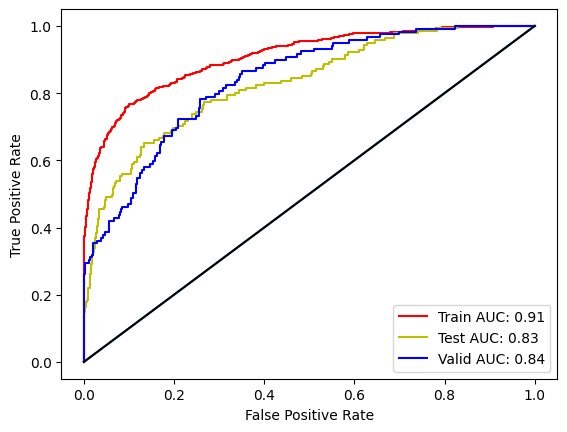

In [39]:
#Plot the ROC Curves - ensure to use the predicted probabilities and not the predicted values
auc_train_cust = roc_auc_score(y_cust_train, y_cust_train_prob_CATB)
auc_test_cust = roc_auc_score(y_cust_test, y_cust_test_prob_CATB)
auc_valid_cust = roc_auc_score(y_cust_valid, y_cust_valid_prob_CATB)

fpr_train, tpr_train, thresholds_train = roc_curve(y_cust_train, y_cust_train_prob_CATB)
fpr_test, tpr_test, thresholds_test = roc_curve(y_cust_test, y_cust_test_prob_CATB)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_cust_valid, y_cust_valid_prob_CATB)

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train_cust)
plt.plot(fpr_test, tpr_test,'y-', label = 'Test AUC: %.2f'%auc_test_cust)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid_cust)
plt.plot([0,1],[0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [40]:
#Compare the two CatBoost models using the research paper features vs XGBoost Models using both the research paper features and our own set of features along with LightGBM using the research paper features.
print('Model AUC')
print('XGBoost Research Paper Model:      %.2f%%'%(roc_auc_score(y_valid_paper, y_valid_paper_prob)*100))
print('XGBoost Our Tuned Model:           %.2f%%'%(roc_auc_score(y_valid, y_valid_prob)*100))
print('LightGBM Research Paper Model:     %.2f%%'%(roc_auc_score(y_valid_paper.thirtyday_expire_flag, y_valid_prob_LGBM)*100))
print('CatBoost Research Paper Model:     %.2f%%'%(roc_auc_score(y_valid_paper.thirtyday_expire_flag, y_valid_paper_prob_CATB)*100))
print('CatBoost Our Tuned Model:          %.2f%%'%(roc_auc_score(y_cust_valid.thirtyday_expire_flag, y_cust_valid_prob_CATB)*100))
print('')

print('Model Accuracy')
print('XGBoost Research Paper Model:      %.2f%%'%(calc_accuracy(y_valid_paper, y_valid_paper_preds)*100))
print('XGBoost Our Tuned Model:           %.2f%%'%(calc_accuracy(y_valid, y_valid_preds)*100))
print('LightGBM Research Paper Model:     %.2f%%'%(calc_accuracy(y_valid_paper.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('CatBoost Research Paper Model:     %.2f%%'%(calc_accuracy(y_valid_paper.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('CatBoost Our Tuned Model:          %.2f%%'%(calc_accuracy(y_cust_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')


Model AUC
XGBoost Research Paper Model:      80.41%
XGBoost Our Tuned Model:           83.94%
LightGBM Research Paper Model:     81.66%
CatBoost Research Paper Model:     83.79%
CatBoost Our Tuned Model:          83.78%

Model Accuracy
XGBoost Research Paper Model:      85.67%
XGBoost Our Tuned Model:           86.55%
LightGBM Research Paper Model:     87.13%
CatBoost Research Paper Model:     87.13%
CatBoost Our Tuned Model:          86.40%



We do not see any improvement in AUC or accuracy when analyzing CatBoost using our tuned model features relative to CatBoost using the research paper features.

##Comparing the various models

In [42]:
#We will compare the validation set characteristics across the three models using the feature set from the research paper along with the CatBoost model using our feature set based on permutation importance.

print('Model AUC')
print('XGBoost:           %.2f%%'%(roc_auc_score(y_valid, y_valid_paper_prob)*100))
print('XGBoost Custom:    %.2f%%'%(roc_auc_score(y_valid, y_valid_prob)*100))
print('LightGBM:          %.2f%%'%(roc_auc_score(y_valid, y_valid_prob_LGBM)*100))
print('CatBoost:          %.2f%%'%(roc_auc_score(y_valid, y_valid_paper_prob_CATB)*100))
print('CatBoost Custom:   %.2f%%'%(roc_auc_score(y_valid, y_cust_valid_prob_CATB)*100))
print('')

print('Model Accuracy')
print('XGBoost:           %.2f%%'%(calc_accuracy(y_valid, y_valid_paper_preds)*100))
print('XGBoost Custom:    %.2f%%'%(calc_accuracy(y_valid, y_valid_preds)*100))
print('LightGBM:          %.2f%%'%(calc_accuracy(y_valid, y_valid_preds_LGBM)*100))
print('CatBoost:          %.2f%%'%(calc_accuracy(y_valid, y_valid_paper_preds_CATB)*100))
print('CatBoost Custom:   %.2f%%'%(calc_accuracy(y_valid, y_cust_valid_preds_CATB)*100))
print('')

print('Recall: True Positive')
print('XGBoost:           %.2f%%'%(calc_recall(y_valid.thirtyday_expire_flag, y_valid_paper_preds)*100))
print('XGBoost Custom:    %.2f%%'%(calc_recall(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('LightGBM:          %.2f%%'%(calc_recall(y_valid.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('CatBoost:          %.2f%%'%(calc_recall(y_valid.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('CatBoost Custom:   %.2f%%'%(calc_recall(y_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')

print('Specificity: True Negative')
print('XGBoost:           %.2f%%'%(calc_specificity(y_valid.thirtyday_expire_flag, y_valid_paper_preds)*100))
print('XGBoost Custom:    %.2f%%'%(calc_specificity(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('LightGBM:          %.2f%%'%(calc_specificity(y_valid.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('CatBoost:          %.2f%%'%(calc_specificity(y_valid.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('CatBoost Custom:   %.2f%%'%(calc_specificity(y_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')

print('Fall Out: False Positive')
print('XGBoost:           %.2f%%'%(calc_fallout(y_valid.thirtyday_expire_flag, y_valid_paper_preds)*100))
print('XGBoost Custom:    %.2f%%'%(calc_fallout(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('LightGBM:          %.2f%%'%(calc_fallout(y_valid.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('CatBoost:          %.2f%%'%(calc_fallout(y_valid.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('CatBoost Custom:   %.2f%%'%(calc_fallout(y_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')

print('Miss Rate: False Negative')
print('XGBoost:           %.2f%%'%(calc_missrate(y_valid.thirtyday_expire_flag, y_valid_paper_preds)*100))
print('XGBoost Custom:    %.2f%%'%(calc_missrate(y_valid.thirtyday_expire_flag, y_valid_preds)*100))
print('LightGBM:          %.2f%%'%(calc_missrate(y_valid.thirtyday_expire_flag, y_valid_preds_LGBM)*100))
print('CatBoost:          %.2f%%'%(calc_missrate(y_valid.thirtyday_expire_flag, y_valid_paper_preds_CATB)*100))
print('CatBoost Custom:   %.2f%%'%(calc_missrate(y_valid.thirtyday_expire_flag, y_cust_valid_preds_CATB)*100))
print('')
print('Precision: Positive Results Relative to Predicted Positive Results')
print('XGBoost:           %.2f%%'%(calc_precision(y_valid, y_valid_paper_preds)*100))
print('XGBoost Custom:    %.2f%%'%(calc_precision(y_valid, y_valid_preds)*100))
print('LightGBM:          %.2f%%'%(calc_precision(y_valid, y_valid_preds_LGBM)*100))
print('CatBoost:          %.2f%%'%(calc_precision(y_valid, y_valid_paper_preds_CATB)*100))
print('CatBoost Custom:   %.2f%%'%(calc_precision(y_valid, y_cust_valid_preds_CATB)*100))
print('')

Model AUC
XGBoost:           80.41%
XGBoost Custom:    83.94%
LightGBM:          81.66%
CatBoost:          83.79%
CatBoost Custom:   83.78%

Model Accuracy
XGBoost:           85.67%
XGBoost Custom:    86.55%
LightGBM:          87.13%
CatBoost:          87.13%
CatBoost Custom:   86.40%

Recall: True Positive
XGBoost:           95.75%
XGBoost Custom:    96.64%
LightGBM:          98.94%
CatBoost:          97.70%
CatBoost Custom:   96.99%

Specificity: True Negative
XGBoost:           37.82%
XGBoost Custom:    38.66%
LightGBM:          31.09%
CatBoost:          36.97%
CatBoost Custom:   36.13%

Fall Out: False Positive
XGBoost:           62.18%
XGBoost Custom:    61.34%
LightGBM:          68.91%
CatBoost:          63.03%
CatBoost Custom:   63.87%

Miss Rate: False Negative
XGBoost:           4.25%
XGBoost Custom:    3.36%
LightGBM:          1.06%
CatBoost:          2.30%
CatBoost Custom:   3.01%

Precision: Positive Results Relative to Predicted Positive Results
XGBoost:           87.97%
X

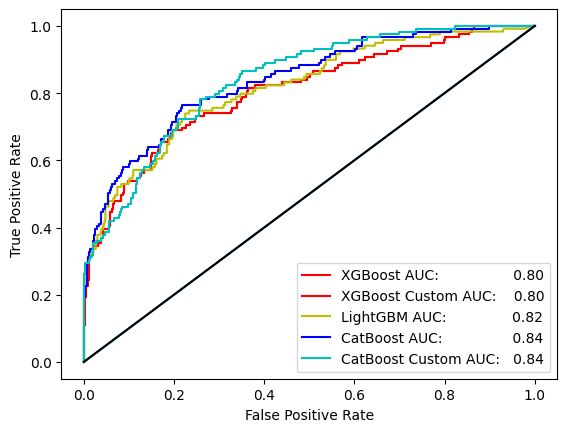

In [43]:
#Plot the test ROC curves across the three models
auc_XGBoost = roc_auc_score(y_valid, y_valid_paper_prob)
auc_LGBM = roc_auc_score(y_valid, y_valid_prob_LGBM)
auc_CATB = roc_auc_score(y_valid, y_valid_paper_prob_CATB)
auc_CATB_cust = roc_auc_score(y_valid, y_cust_valid_prob_CATB)

fpr_XGBoost, tpr_XGBoost, thresholds_XGBoost = roc_curve(y_valid, y_valid_paper_prob)
fpr_LGBM, tpr_LGBM, thresholds_LGBM = roc_curve(y_valid, y_valid_prob_LGBM)
fpr_CatBoost, tpr_CatBoost, thresholds_CatBoost = roc_curve(y_valid, y_valid_paper_prob_CATB)
fpr_CatBoost_cust, tpr_CatBoost_cust, thresholds_CatBoost_cust = roc_curve(y_valid, y_cust_valid_prob_CATB)

plt.plot(fpr_XGBoost, tpr_XGBoost,'r-', label = 'XGBoost AUC:                 %.2f'%auc_XGBoost)
plt.plot(fpr_XGBoost, tpr_XGBoost,'r-', label = 'XGBoost Custom AUC:    %.2f'%auc_XGBoost)
plt.plot(fpr_LGBM, tpr_LGBM,'y-', label = 'LightGBM AUC:               %.2f'%auc_LGBM)
plt.plot(fpr_CatBoost, tpr_CatBoost,'b-',label = 'CatBoost AUC:                %.2f'%auc_CATB)
plt.plot(fpr_CatBoost_cust, tpr_CatBoost_cust,'c-',label = 'CatBoost Custom AUC:   %.2f'%auc_CATB_cust)
plt.plot([0,1],[0,1],[0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()